```
This software is a part of GPU Ocean.

Copyright (C) 2019, 2020  SINTEF Digital

Investigating algorithms to run a tailored version of LETKF

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# LETKF for drifter-based observations


## Set environment

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc

import pycuda.driver as cuda
import os
import sys
import datetime

from importlib import reload
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Import our simulator
from SWESimulators import IPythonMagic, SimReader, Observation, DoubleJetCase
from SWESimulators import DataAssimilationUtils as dautils

In [ ]:
%cuda_context_handler gpu_ctx

### The data path
Loading the true state used in the Double Jet experiments

In [ ]:
truth_path = os.path.abspath('../../../data/true_state/')

In [ ]:
os.listdir(truth_path)

['double_jet_case_truth.nc', 'drifter_observations.pickle', 'info.txt']

### Define functions for plotting

In [ ]:
def imshow(im, interpolation="None", title=None, figsize=(4,4), interior=False):
    fig = plt.figure(figsize=figsize)
    
    if interior:
        im = plt.imshow(im[2:-2,2:-2], interpolation=interpolation, origin='lower')
    else:
        im = plt.imshow(im, interpolation=interpolation, origin='lower')
    
    plt.colorbar()
    if title is not None:
        plt.title(title)
        
def imshow3(eta, hu, hv, interpolation="None", title=None, figsize=(12.5,3.4), interior=False):
    fig, axs = plt.subplots(1,3, figsize=figsize)
    
    eta_cmap = 'BrBG'
    huv_cmap = 'RdBu'
    
    range_eta = np.max(np.abs(eta))
    range_huv = max(np.max(np.abs(hu)), np.max(np.abs(hv)))
    
    range_eta = 3.5
    range_huv = 625
    
    if interior:
        eta_im = axs[0].imshow(eta[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=-range_eta, vmax=range_eta, cmap=eta_cmap)
    else:
        eta_im = axs[0].imshow(eta, interpolation=interpolation, origin='lower', vmin=-range_eta, vmax=range_eta, cmap=eta_cmap)
    axs[0].set_title("$\eta$")
    plt.colorbar(eta_im, ax=axs[0])
    
    if interior:
        hu_im = axs[1].imshow(hu[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv, cmap=huv_cmap)
    else:
        hu_im = axs[1].imshow(hu, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv, cmap=huv_cmap)
    axs[1].set_title("$hu$")
    plt.colorbar(hu_im, ax=axs[1])

    if interior:
        hv_im = axs[2].imshow(hv[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv, cmap=huv_cmap)
    else:
        hv_im = axs[2].imshow(hv, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv, cmap=huv_cmap)
    axs[2].set_title("$hv$")
    plt.colorbar(hv_im, ax=axs[2])

    if title is not None:
        plt.suptitle(title)
    plt.tight_layout()
    
def plotDrifters(observations, sim_reader, t, drifter_set=[], field_data=None, drifter_set_only=True):
    drifter_positions = observations.get_drifter_position(t)

    fig = plt.figure(figsize=(7,7))
    ax = plt.subplot(111)
    nx, ny = sim_reader.get('nx'), sim_reader.get('ny')
    dx, dy = sim_reader.get('dx'), sim_reader.get('dy')

    if field_data is None:
        emptyData =np.ma.masked_where(np.zeros((ny,nx)) > 1, np.zeros((ny,nx)))
        fd = ax.imshow(emptyData, origin="lower", extent=[0, nx*dx, 0, ny*dy], cmap='binary')
    else:
        fd = ax.imshow(field_data, origin="lower", extent=[0, nx*dx, 0, ny*dy])
    plt.colorbar(fd)
        
    for i in range(drifter_positions.shape[0]):
        color = 'xkcd:pale cyan'
        if i in drifter_set:
            color = 'xkcd:tomato red'
        elif drifter_set_only:
            continue
        circ_end = matplotlib.patches.Circle((drifter_positions[i,0], drifter_positions[i,1]),
                                             3000, fill=True, zorder=10, color=color)
        ax.add_patch(circ_end)
        
def plotDriftersOnField(observations, sim_reader, t, drifter_set=[]):
    drifter_positions = observations.get_drifter_position(t)
    

    
def days_to_sec(days):
    return days*24*60*60

def truth_time_step(t):
    t = t - days_to_sec(3)
    return int(t/(60*60))

# The double jet steady state

In [ ]:
truth_state_filename = os.path.join(truth_path, "double_jet_case_truth.nc")
observations_filename = os.path.join(truth_path, "drifter_observations.pickle")

truth_reader = SimReader.SimNetCDFReader(truth_state_filename)
dx, dy = truth_reader.get('dx'), truth_reader.get('dy')
nx, ny = truth_reader.get('nx'), truth_reader.get('ny')
print(dx, dy)
print(nx, ny)
domain_size_x = nx*dx
domain_size_y = ny*dy

use_drifters = True

observation_type = dautils.ObservationType.StaticBuoys
if use_drifters:
    observation_type = dautils.ObservationType.UnderlyingFlow

observations = Observation.Observation(observation_type=observation_type, 
                                       domain_size_x=domain_size_x, domain_size_y=domain_size_y,
                                       nx=nx, ny=ny)
observations.read_pickle(observations_filename)


if use_drifters:
    #drifter_set = np.arange(0, 64, 7)
    internal_drifter_set = [ 2,  7, 12, 24, 29, 35, 41, 48, 53, 60]
    observations.setDrifterSet(internal_drifter_set)
    
drifter_set = np.arange(observations.get_num_drifters())

2220.0 2220.0
500 300


## Plot initial state (day 3)

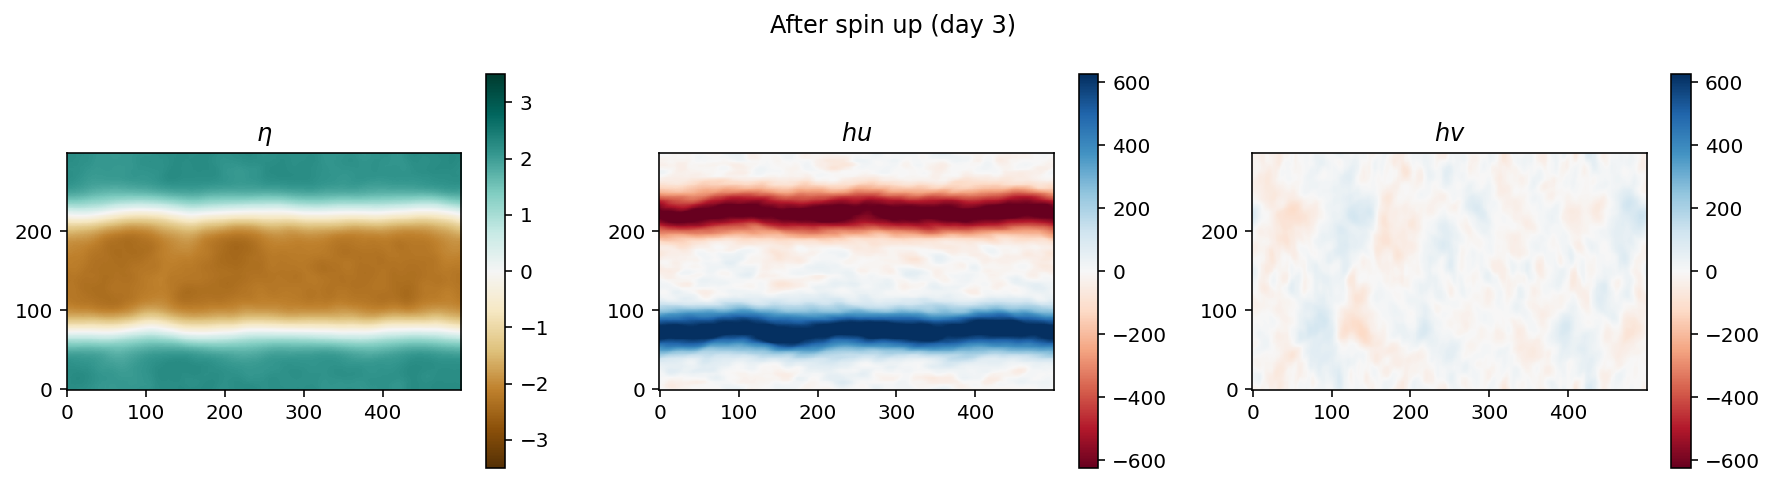

In [ ]:
day = 3
title = "After spin up"
title = title + " (day " + str(day) + ")"
t = days_to_sec(day)
t_index = truth_time_step(t)
eta, hu, hv, t = truth_reader.getTimeStep(t_index)
imshow3(eta, hu, hv, title=title)

# Initial drifters


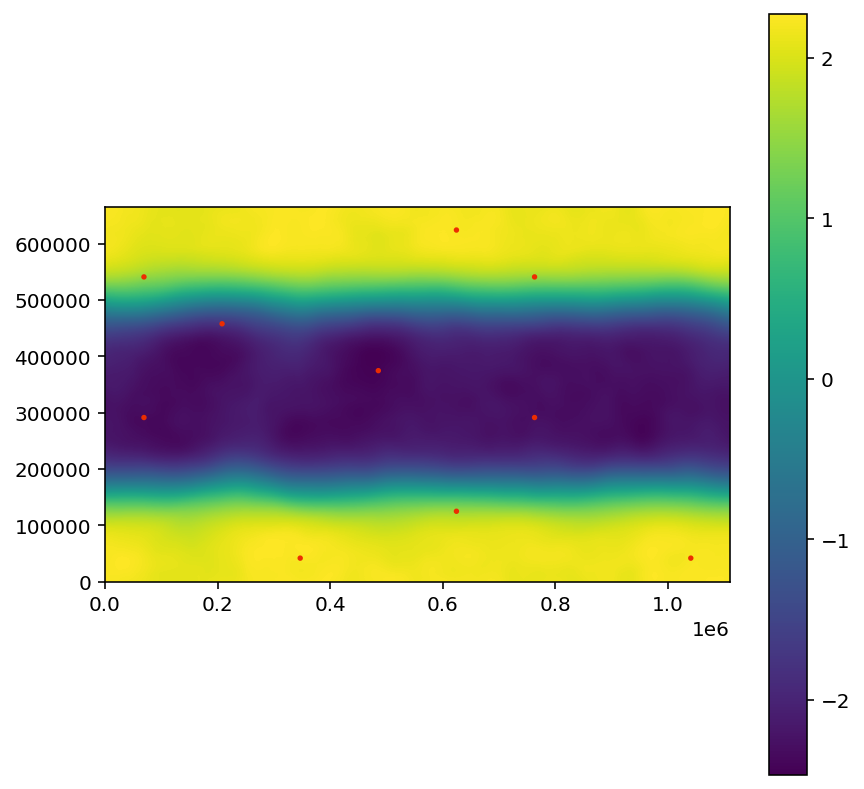

In [ ]:
t_spinup = days_to_sec(3)
plotDrifters(observations, truth_reader, t_spinup, drifter_set, field_data=eta)



# Pseudo code for our LETKF

### Utility functions

In [ ]:
def getLocalIndices(obs_loc, boxed_r, dx, dy, nx, ny):
    """ 
    Defines mapping from global domain (nx times ny) to local domain
    """
    
    localIndices = np.array([[False]*nx]*ny)
    
    obs_loc_cellID = (np.int(obs_loc[0]//dx), np.int(obs_loc[1]//dy))

    #print(obs_loc_cellID)
    loc_cell_left  = np.int((obs_loc[0]-boxed_r   )//dx)
    loc_cell_right = np.int((obs_loc[0]+boxed_r+dx)//dx)
    loc_cell_down  = np.int((obs_loc[1]-boxed_r   )//dy)
    loc_cell_up    = np.int((obs_loc[1]+boxed_r+dy)//dy)

    xranges = []
    yranges = []
    
    xroll = 0
    yroll = 0

    if loc_cell_left < 0:
        xranges.append((nx+loc_cell_left, nx))
        xroll = loc_cell_left  # negative number
        loc_cell_left = 0
    elif loc_cell_right > nx:
        xranges.append((0, loc_cell_right - nx))
        xroll = loc_cell_right - nx   # positive number
        loc_cell_right = nx
    xranges.append((loc_cell_left, loc_cell_right))

    if loc_cell_down < 0:
        yranges.append((ny+loc_cell_down, ny))
        yroll = loc_cell_down   # negative number
        loc_cell_down = 0
    elif loc_cell_up > ny:
        yranges.append((0, loc_cell_up - ny))
        yroll = loc_cell_up - ny   # positive number
        loc_cell_up = ny
    yranges.append((loc_cell_down, loc_cell_up))


    #print(nx, ny)
    #print(loc_cell_left, loc_cell_right, loc_cell_down, loc_cell_up)
    #print(xranges)
    #print(yranges)

    #print(localIndices.shape)
    for xrange in xranges:
        for yrange in yranges:
            localIndices[yrange[0]:yrange[1], xrange[0]:xrange[1]] = True

            for y in range(yrange[0],yrange[1]):
                for x in range(xrange[0], xrange[1]):
                    loc = np.array([(x+0.5)*dx, (y+0.5)*dy])

    return localIndices, xroll, yroll
        



In [ ]:
def dist(obs, loc, r, slope_factor, lx, ly):
    if len(loc.shape) == 1:
        dist = min(np.linalg.norm(np.abs(obs-loc)),
                   np.linalg.norm(np.abs(obs-loc) - np.array([lx,0 ])),
                   np.linalg.norm(np.abs(obs-loc) - np.array([0 ,ly])),
                   np.linalg.norm(np.abs(obs-loc) - np.array([lx,ly])) )
    else:
        dist = np.linalg.norm(obs-loc, axis=1)
    
    return 1 - (1 + np.tanh((dist-r)/slope_factor))/2


def getLocalWeightShape(scale_r, scale_slope, dx, dy, nx, ny):
    
    local_nx = int(boxed_r*2/dx)+1
    local_ny = int(boxed_r*2/dy)+1
    weights = np.zeros((local_ny, local_ny))
    
    obs_loc_cellID = (local_ny, local_nx)
    obs_loc = np.array([local_nx*dx/2, local_ny*dy/2])
    #print(obs_loc)
    #print(obs_loc[0]/dx, obs_loc[1]/dy)

    for y in range(local_ny):
        for x in range(local_nx):
            loc = np.array([(x+0.5)*dx, (y+0.5)*dy])
            weights[y,x] = min(1, dist(obs_loc, loc, scale_r, scale_slope, nx*dx, ny*dy))
                        
        
    return weights
        



In [ ]:
def getCombinedWeights(observation_positions, boxed_r, scale_r, scale_slope, dx, dy, nx, ny):
    W_scale = np.zeros((ny, nx))
    
    num_drifters = observation_positions.shape[0]
    #print('found num_drifters:', num_drifters)
    if observation_positions.shape[1] != 2:
        print('observation_positions has wrong shape')
        return None

    # Get the shape of the local weights (drifter independent)
    W_loc = getLocalWeightShape(scale_r, scale_slope, dx, dy, nx, ny)
    
    for d in range(num_drifters):
        # Get local mapping for drifter 
        L, xroll, yroll = getLocalIndices(observation_positions[d,:], boxed_r, dx, dy, nx, ny)

        # Roll weigths according to periodic boundaries
        W_loc_d = np.roll(np.roll(W_loc, shift=yroll, axis=0 ), shift=xroll, axis=1)
        
        # Add weights to global domain based on local mapping:
        W_scale[L] += W_loc_d.flatten()
        
    return W_scale


        

    

### Parameters

In [ ]:
# Parameters:
r_factor = 20
drop_factor = 8
boxed_r = dx*((r_factor/2)+drop_factor)*2

### Testing utility functions

In [ ]:
%%time
L, xroll, yroll = getLocalIndices(observations.get_drifter_position(t)[1,:], boxed_r, dx, dy, nx, ny)

Wall time: 55 ms


5329
73.0
36.0
(xroll, yroll) (5, -18)


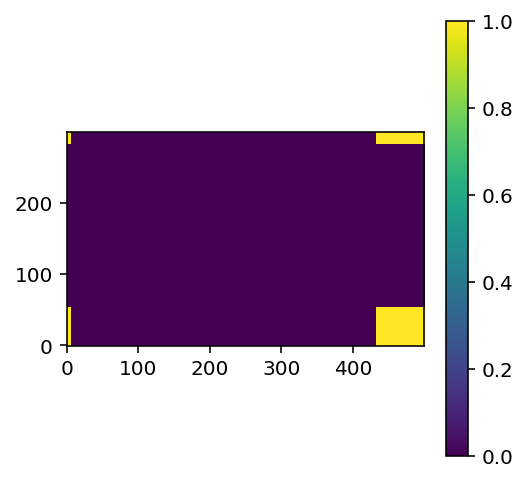

In [ ]:
imshow(L)
print(np.sum(L))
print(np.sqrt(np.sum(L)))
print(boxed_r/dx)
print('(xroll, yroll)', (xroll, yroll))

In [ ]:
%%time
W_loc_shape = getLocalWeightShape(r_factor*dx*1.5, drop_factor*dx, dx, dy, nx, ny)

Wall time: 328 ms


(73, 73)


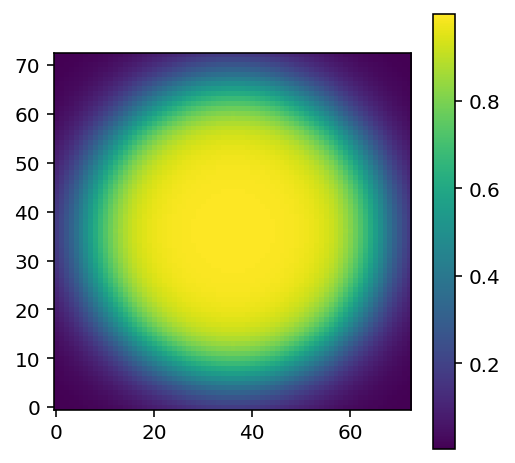

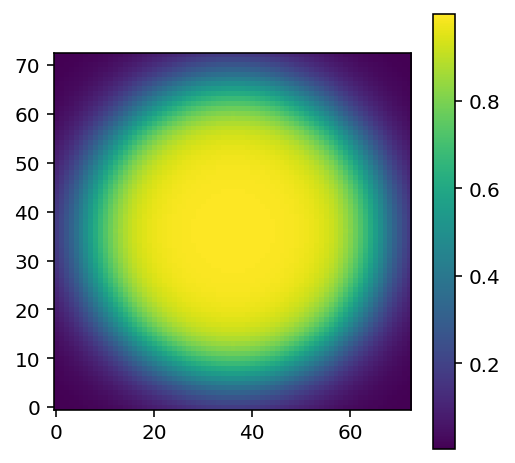

In [ ]:
print(W_loc_shape.shape)
imshow(W_loc_shape)
W_flat = W_loc_shape.flatten()
imshow(W_flat.reshape(W_loc_shape.shape))

(300, 500) (5329,) (73, 73) (300, 500)
Wall time: 87 ms


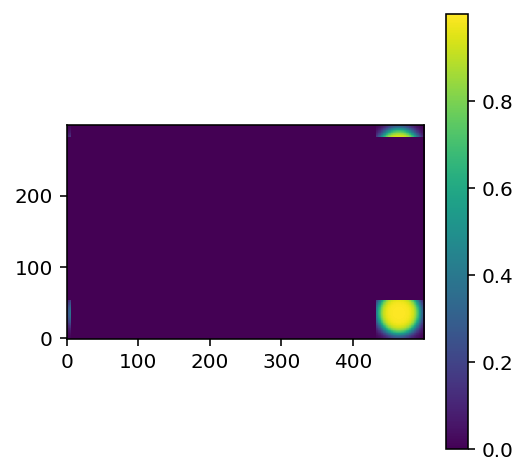

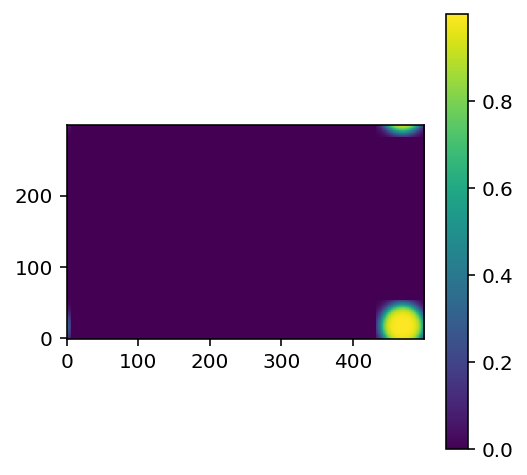

In [ ]:
%%time
# Transformation from local weights to global domain
W = np.zeros((ny, nx))
print(W.shape, W[L].shape, W_loc_shape.shape, L.shape)

W[L] = W_loc_shape.flatten()
imshow(W)

W2 = np.zeros((ny, nx))
tmp_W_loc = np.roll(np.roll(W_loc_shape, shift=yroll, axis=0 ), shift=xroll, axis=1)
W2[L] = tmp_W_loc.flatten()
imshow(W2)

In [ ]:
test = np.arange(24).reshape(4,6)
print(test)
print(np.roll(test, shift=1, axis=0))

[[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]
 [18 19 20 21 22 23]]
[[18 19 20 21 22 23]
 [ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]]


In [ ]:
%%time
W_scale = getCombinedWeights(observations.get_drifter_position(t), boxed_r,
                          r_factor*dx*1.5, drop_factor*dx, dx, dy, nx, ny)

Wall time: 628 ms


In [ ]:
observations.get_drifter_position(t)

array([[ 346875.,   41625.],
       [1040625.,   41625.],
       [ 624375.,  124875.],
       [  69375.,  291375.],
       [ 763125.,  291375.],
       [ 485625.,  374625.],
       [ 208125.,  457875.],
       [  69375.,  541125.],
       [ 763125.,  541125.],
       [ 624375.,  624375.]], dtype=float32)

(300, 500)
0.9994472213630764 0.0
1.0 1.0


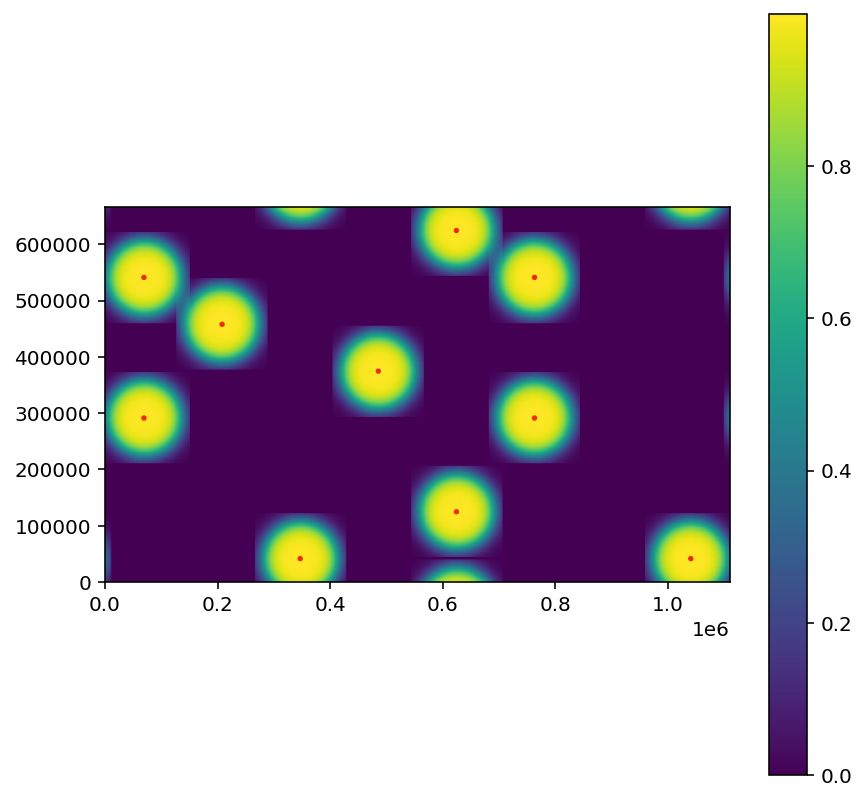

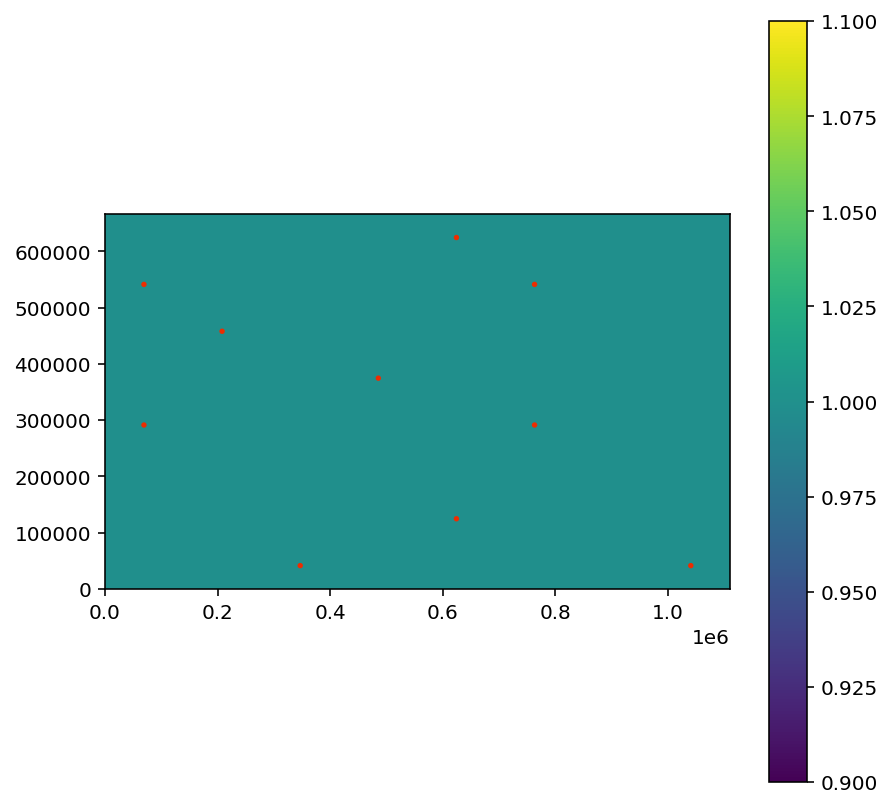

In [ ]:
print(W_scale.shape)
plotDrifters(observations, truth_reader, t_spinup, drifter_set, W_scale)
print(np.max(W_scale), np.min(W_scale))

W_scale_scaled = np.maximum(W_scale, 1)
print(np.max(W_scale_scaled), np.min(W_scale_scaled))

plotDrifters(observations, truth_reader, t_spinup, drifter_set, W_scale_scaled)


### Main LETKF pseudo-code

In [ ]:
%%time
# Pre-processing (assuming moorings)
##################

# Obtain weight structure
W_loc = getLocalWeightShape(r_factor*dx*1.5, drop_factor*dx, dx, dy, nx, ny)

# Combined weights
W_combined = getCombinedWeights(observations.get_drifter_position(t), boxed_r,
                                r_factor*dx*1.5, drop_factor*dx, dx, dy, nx, ny)

W_scale = np.maximum(W_combined, 1)

W_forecast = np.ones_like(W_scale) - W_combined/W_scale



Wall time: 854 ms


In [ ]:
%%time
##################
# DA
##################

# Get observations (and ensemble observations + perturbations, etc)
observation_positions = observations.get_drifter_position(t)
numDrifters = observation_positions.shape[0]

# Gather all the forecasts
Xf = [numEnsembleMembers, [eta, hu, hv]] 
numEnsembleMembers = 1 # Example of only Ne=1

Xa = [numEnsembleMembers, [np.zeros((ny, nx)), np.zeros((ny, nx)), np.zeros((ny, nx))]]


# Loop over each observation
for d in range(numDrifters):
    
    L, xroll, yroll = getLocalIndices(observations.get_drifter_position(t)[d,:], boxed_r, dx, dy, nx, ny)
    

    # For each ensemble member, create eta_loc, hu_loc, hv_loc
    xf_loc_vars = [numEnsembleMembers, [eta[L], hu[L], hv[L]]]
    
    for e in range(numEnsembleMembers):
        # for eta, hu,
        for i in range(3): 
            # roll the local domain so that it does not go through the boundaries
            xf_loc_vars[e][i] = np.roll(np.roll(xf_loc_vars[e][i].reshape(W_loc.shape), shift=-yroll, axis=0 ), shift=-xroll, axis=1)

            # Local state vectors as 1D
            xf_loc_vars[e][i] = xf_loc_vars[e][i].flatten()
        
    # Do the same operations on the W_scale
    #W_scale_loc = np.roll(np.roll(W_scale[L].reshape(W_loc.shape), shift=-yroll, axis=0 ), shift=-xroll, axis=1)
    #W_scale_loc = W_scale_loc.flatten()
    
                
    # LETKF - here, we just use a dummy analysis
    xa_loc_vars = [[np.ones_like(xf_loc_vars[0][0]), 
                    np.ones_like(xf_loc_vars[0][1]), 
                    np.ones_like(xf_loc_vars[0][2])]]
    
    # For each ensemble member, apply weight and add to global Xa
    for e in range(numEnsembleMembers):
        for i in range(3):
            WaXa_loc = xa_loc_vars[e][i]*W_loc.flatten()/W_scale_loc.flatten()

            # Roll the local domain back according to periodic boundaries again
            WaXa_loc = np.roll(np.roll(WaXa_loc.reshape(W_loc.shape), shift=yroll, axis=0 ), shift=xroll, axis=1)

            # Add to global Xa
            Xa[e][i][L] += WaXa_loc.flatten()
        
    
# Scale the forecast
for i in range(3):
    Xf[0][i] = W_forecast*Xf[0][i] + Xa[0][i]
    

NameError: name 'numEnsembleMembers' is not defined

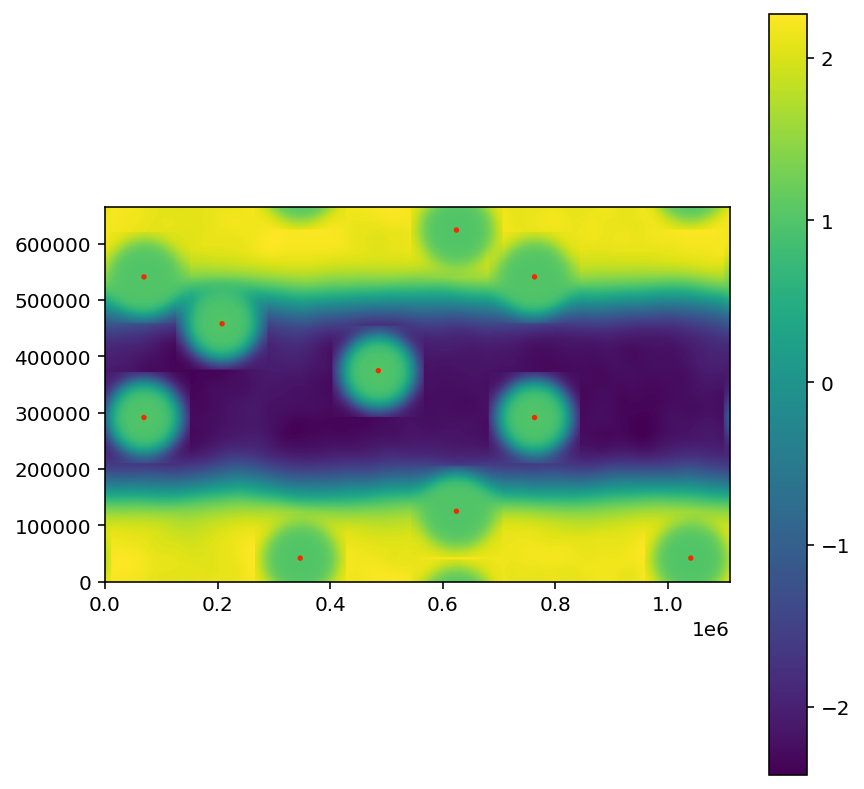

In [ ]:
plotDrifters(observations, truth_reader, t_spinup, drifter_set, field_data=Xf[0][0])